In [14]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers.legacy import Adam


In [15]:
df = pd.read_csv('../../data/final/2022.csv').drop(columns=['Unnamed: 0'])
df.head()



,player_id,Player,Nation,Pos,Squad,Comp,Age,Gls,Ast,G+A,G-PK,G+A-PK,xG,xAG,xG+xAG,npxG,npxG+xAG
0,1000,Salis Abdul Samed,GHA,MF,Lens,Ligue 1,22,0.03,0.03,0.06,0.03,0.06,0.03,0.05,0.08,0.03,0.08
1,1001,Francesco Acerbi,ITA,DF,Inter,Serie A,34,0.00,0.07,0.07,0.00,0.07,0.04,0.04,0.08,0.04,0.08
2,1002,Marcos Acuña,ARG,DF,Sevilla,La Liga,30,0.14,0.09,0.24,0.14,0.24,0.05,0.20,0.26,0.05,0.26
3,1003,Karim Adeyemi,GER,"FW,MF",Dortmund,Bundesliga,20,0.39,0.32,0.71,0.39,0.71,0.33,0.24,0.57,0.28,0.52
4,1004,Yacine Adli,FRA,"MF,FW",Milan,Serie A,22,0.00,0.00,0.00,0.00,0.00,0.05,0.16,0.22,0.05,0.22


In [16]:
reference_data = ['player_id', 'Player', 'Nation', 'Pos', 'Squad', 'Comp', 'Age']
X = df.drop(columns=['player_id', 'Player', 'Nation', 'Pos', 'Squad', 'Comp', 'Age', 'Gls', 'Ast', 'xAG', 'npxG+xAG', 'npxG'])
y = df['Gls']
print(X.shape, y.shape)

(926, 5) (926,)


In [17]:
# Splitting the data, 80% train, 10% cross-validation, 10% test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.20, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1)
print("X_train.shape:", X_train.shape, "X_cv.shape:", X_cv.shape, "X_test.shape:", X_test.shape)
print("y_train.shape:",y_train.shape, "y_cv.shape:", y_cv.shape, "y_test.shape:", y_test.shape)

X_train.shape: (740, 5) X_cv.shape: (93, 5) X_test.shape: (93, 5)
y_train.shape: (740,) y_cv.shape: (93,) y_test.shape: (93,)


In [18]:
normalizer = tf.keras.layers.Normalization(input_shape=[X_train.shape[1],])
normalizer.adapt(np.array(X_train))
print(normalizer.mean.numpy())

first = np.array(X_train[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

[[0.17756179 0.09147105 0.17051736 0.11033977 0.18523744]]
First example: [[1.06 0.1  1.06 0.18 0.64]]

Normalized: [[2.67 0.05 2.76 0.32 1.68]]


In [19]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1, activation='linear')
])

In [20]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-3)

model.compile(optimizer=optimizer, 
              loss='mean_squared_error',
              metrics=['mean_absolute_error'])

In [21]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X_train, y_train, epochs=18, validation_data=(X_cv, y_cv), callbacks=[early_stop])


Epoch 1/18
24/24 [==============================] - 0s 4ms/step - loss: 0.0104 - mean_absolute_error: 0.0463 - val_loss: 0.0018 - val_mean_absolute_error: 0.0268
Epoch 2/18
24/24 [==============================] - 0s 1ms/step - loss: 0.0031 - mean_absolute_error: 0.0275 - val_loss: 5.1659e-04 - val_mean_absolute_error: 0.0104
Epoch 3/18
24/24 [==============================] - 0s 1ms/step - loss: 0.0014 - mean_absolute_error: 0.0178 - val_loss: 4.3146e-04 - val_mean_absolute_error: 0.0157
Epoch 4/18
24/24 [==============================] - 0s 998us/step - loss: 0.0013 - mean_absolute_error: 0.0183 - val_loss: 7.6483e-04 - val_mean_absolute_error: 0.0197
Epoch 5/18
24/24 [==============================] - 0s 1ms/step - loss: 0.0012 - mean_absolute_error: 0.0200 - val_loss: 2.0034e-04 - val_mean_absolute_error: 0.0080
Epoch 6/18
24/24 [==============================] - 0s 981us/step - loss: 9.8194e-04 - mean_absolute_error: 0.0155 - val_loss: 3.5415e-04 - val_mean_absolute_error: 0.0102


In [22]:
loss, mae = model.evaluate(X_test, y_test)
print('Test loss:', loss)
print('Test MAE:', mae)


3/3 [==============================] - 0s 1ms/step - loss: 0.0019 - mean_absolute_error: 0.0131
Test loss: 0.0019371105590835214
Test MAE: 0.013091507367789745


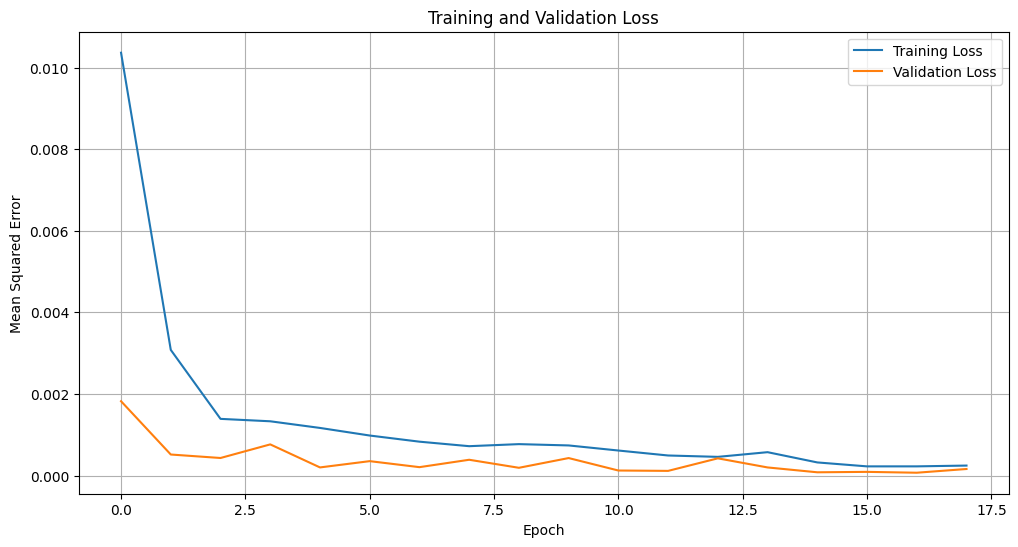

In [23]:

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()


In [24]:
predictions = model.predict(X_test)


3/3 [==============================] - 0s 796us/step


In [25]:
# Save model
model.save('model.h5')

/Users/veer/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [26]:
df_test = pd.read_csv('../../data/final/2023.csv').drop(columns=['Unnamed: 0'])

df_test.head()

,player_id,Player,Nation,Pos,Squad,Comp,Age,Gls,Ast,G+A,G-PK,G+A-PK,xG,xAG,xG+xAG,npxG,npxG+xAG
0,1000,Brenden Aaronson,USA,MF,Union Berlin,Bundesliga,22,0.0,0.0,0.0,0.0,0.0,0.01,0.09,0.11,0.01,0.11
1,1001,Salis Abdul Samed,GHA,MF,Lens,Ligue 1,23,0.0,0.0,0.0,0.0,0.0,0.03,0.03,0.05,0.03,0.05
2,1002,Francesco Acerbi,ITA,DF,Inter,Serie A,35,0.0,0.0,0.0,0.0,0.0,0.11,0.00,0.11,0.11,0.11
3,1003,Marcos Acuña,ARG,DF,Sevilla,La Liga,31,0.0,0.0,0.0,0.0,0.0,0.04,0.06,0.10,0.04,0.10
4,1004,Karim Adeyemi,GER,"FW,MF",Dortmund,Bundesliga,21,0.0,0.0,0.0,0.0,0.0,0.43,0.05,0.48,0.43,0.48


In [27]:
reference_data_new = df_test[['player_id', 'Player', 'Nation', 'Pos', 'Squad', 'Comp', 'Age']]
X_new = df_test.drop(columns=['player_id', 'Player', 'Nation', 'Pos', 'Squad', 'Comp', 'Age', 'Gls', 'Ast', 'xAG', 'npxG+xAG', 'npxG'])

print(X_new.shape)

(732, 5)


In [28]:
predictions = model.predict(X_new)
results = pd.concat([reference_data_new, pd.DataFrame(predictions, columns=['Predicted_Gls'])], axis=1)
results['Predicted_Gls'] = results['Predicted_Gls'].apply(lambda x: max(0, x))


23/23 [==============================] - 0s 454us/step


In [29]:
results.sort_values(by=['Predicted_Gls'], ascending=False).head(20)
results.to_csv('../../data/final/results.csv')